# TensorFlow lab: text mining with SVD

**DISCLAIMER: we're building tools from scratch here because it's a good exercise. In real life use `gensim` or something.**

**DISCLAIMER 2: Also in real life don't use SVD for this. Use NMF or LDA or something. Seriously.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

from collections import defaultdict

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
def preprocess(x):
    """
    Input a string, map it to lower-case and prune out
    the crap we don't want
    """
    #x = x.decode("utf-8", errors="ignore")
    x = x.decode("ascii", errors="ignore")
    for i in "',.!?-*()/":
        x = x.replace(i, " ")
    return x.strip().lower()

In [3]:
textfile = "winereviews.txt"
rawtext = [preprocess(x) for x in open(textfile, "rb").readlines() if len(x) > 5]
len(rawtext)

1230

In [4]:
for i in range(10):
    print(i, rawtext[i])

0 lovely delicate  fragrant rhone wine  polished leather and strawberries  perhaps a bit dilute  but good for drinking now
1 liquorice  cherry fruit  simple and coarse at the finish
2 thin and completely uninspiring
3 rough  no stars
4 big  fat  textured chardonnay   nuts and butterscotch  a slightly odd metallic cardboard finish  but probably
5 a blind tasting  other than the fizz  which included five vintages of cote rotie brune et blonde from guigal
6 surprisingly young feeling and drinking well  but without any great complexity  a good
7 charming  violet fragranced nose  classic guigal cote rotie
8 good grip and a touch of rusticity on the length  va showing through  on the downhill slope  just
9 just about holding together   drying out a touch at the finish  not as good as i thought this would be   a good


In [5]:
stopwords = "and but for the".split()

def tokenizer(x, minlen=3):
    """
    Input a sentence, return a list of tokens.
    """
    return [w for w in x.split() if (w not in stopwords)&(len(w) >= minlen)]

In [6]:
tokens = [tokenizer(d) for d in rawtext]

In [7]:
for i in range(10):
    print(tokens[i])

['lovely', 'delicate', 'fragrant', 'rhone', 'wine', 'polished', 'leather', 'strawberries', 'perhaps', 'bit', 'dilute', 'good', 'drinking', 'now']
['liquorice', 'cherry', 'fruit', 'simple', 'coarse', 'finish']
['thin', 'completely', 'uninspiring']
['rough', 'stars']
['big', 'fat', 'textured', 'chardonnay', 'nuts', 'butterscotch', 'slightly', 'odd', 'metallic', 'cardboard', 'finish', 'probably']
['blind', 'tasting', 'other', 'than', 'fizz', 'which', 'included', 'five', 'vintages', 'cote', 'rotie', 'brune', 'blonde', 'from', 'guigal']
['surprisingly', 'young', 'feeling', 'drinking', 'well', 'without', 'any', 'great', 'complexity', 'good']
['charming', 'violet', 'fragranced', 'nose', 'classic', 'guigal', 'cote', 'rotie']
['good', 'grip', 'touch', 'rusticity', 'length', 'showing', 'through', 'downhill', 'slope', 'just']
['just', 'about', 'holding', 'together', 'drying', 'out', 'touch', 'finish', 'not', 'good', 'thought', 'this', 'would', 'good']


In [8]:
countdict = defaultdict(int)

In [9]:
for doc in tokens:
    for tok in doc:
        countdict[tok] += 1
len(countdict)

2782

In [10]:
countdict["blind"]

3

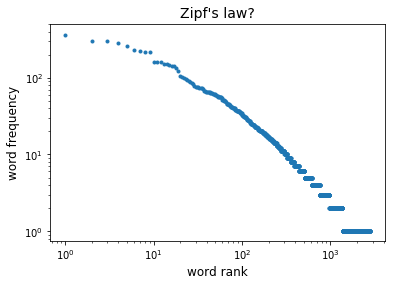

In [11]:
counts = list(countdict.values())
counts.sort(reverse=True)

plt.plot(counts, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("Zipf's law?", fontsize=14)
plt.xlabel("word rank", fontsize=12)
plt.ylabel("word frequency", fontsize=12);

In [12]:
min_counts = 4
allowed_words = [w for w in countdict if (int(countdict[w]) >= min_counts)]

In [13]:
len(allowed_words)

760

In [14]:
# let's convert that list of words to a dictionary from word to index
word_to_index = {allowed_words[i]:i for i in range(len(allowed_words))}
word_to_index["wine"]

4

In [15]:
def corpus_to_sparse_indices(corpus, wti=word_to_index):
    """
    Create inputs for a sparse matrix
    
    :corpus: a list of lists of tokens
    :wti: dictionary mapping words to indices
    """
    indices = []
    vals = []
    
    # for each document in the corpus
    for i in range(len(corpus)):
        index_count = defaultdict(int)
        # for each word in the document
        for token in corpus[i]:
            # if it's in the allowed word list
            if token in wti:
                # keep a count
                index_count[wti[token]] += 1
        # 
        for ind in index_count:
            indices.append([i, ind])
            vals.append(index_count[ind])
    return indices, vals

In [16]:
def corpus_to_dense_matrix(corpus, wti=word_to_index):
    """
    Build a term-document matrix
    
    :corpus: a list of lists of tokens
    :wti: dictionary mapping words to indices
    """
    tdm = np.zeros((len(corpus), len(wti)))
    
    # for each document in the corpus
    for i in range(len(corpus)):
        # for each word in the document
        for token in corpus[i]:
            # if it's in the allowed word list
            if token in wti:
                # increment the matrix element
                tdm[i,wti[token]] += 1
    return tdm

In [17]:
tf.reset_default_graph()

In [18]:
# sparse tensor for our data
#term_doc_matrix = tf.SparseTensor(indices=indices, values=vals, dense_shape=dense_shape)
term_doc_matrix = tf.constant(corpus_to_dense_matrix(tokens, word_to_index))

In [19]:
term_doc_matrix.dtype

tf.float64

In [20]:
term_doc_matrix.get_shape()

TensorShape([Dimension(1230), Dimension(760)])

In [21]:
# define tensorflow variables for the SVD

In [22]:
s_tf, u_tf, v_tf = tf.svd(term_doc_matrix, full_matrices=False, name="svd")

In [23]:
# and lets truncate the vectors
trunc = 100
u_trunc = u_tf[:,:trunc]
v_trunc = v_tf[:,:trunc]
u_trunc

<tf.Tensor 'strided_slice:0' shape=(1230, 100) dtype=float64>

In [24]:
v_tf.name

'Svd:2'

In [25]:
u_trunc.name

'strided_slice:0'

In [26]:
with tf.Session() as sess:
    s, u, v = sess.run([s_tf, u_trunc, v_trunc])

In [27]:
# orig tensor is [M,N]. P = min(M,N)

# s has shape [P]
# u has shape [M,P] (full_matrices=False) or [M,M] otherwise
# v has shape [N,P] (full_matrices=False) or [N,N] otherwise. so I think v[i,:] would be a topic vector

In [28]:
s.shape

(760,)

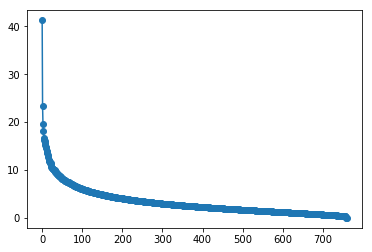

In [29]:
plt.plot(s, "o-");

In [30]:
v.shape

(760, 100)

In [31]:
def summarize_topic(vec, words=allowed_words, n=10):
    """
    Input a vector from v (e.g. v[0,:]) and map back to words
    """
    order = vec.argsort()[::-1]
    output = ""
    for i in range(n):
        output += "%s*%s + "%(round(vec[order[i]],3), words[order[i]]) 
        
    return output[:-3]

In [32]:
for i in range(10):
    print(summarize_topic(v[i,:]))
    print()

0.384*fruit + 0.379*dilute + 0.313*wine + 0.204*rough + 0.122*fragrant + 0.108*classic + 0.108*lovely + 0.1*coarse + 0.075*thin + 0.063*which

0.039*might + 0.036*about + 0.034*dry + 0.032*also + 0.031*beginning + 0.031*length + 0.028*very + 0.026*although + 0.022*slightly + 0.021*great

0.232*about + 0.167*sweetness + 0.141*just + 0.14*was + 0.137*all + 0.133*also + 0.131*dry + 0.13*maturity + 0.114*together + 0.108*style

0.016*was + 0.016*other + 0.015*holding + 0.014*time + 0.014*structure + 0.014*quite + 0.013*dry + 0.013*air + 0.011*which + 0.009*classic

0.541*bit + 0.342*delicate + 0.25*now + 0.248*lovely + 0.167*liquorice + 0.167*drinking + 0.167*rhone + 0.117*wine + 0.105*completely + 0.099*nuts

0.018*sweetness + 0.018*might + 0.016*time + 0.011*vintages + 0.009*dry + 0.009*would + 0.009*about + 0.008*beginning + 0.008*not + 0.008*drying

0.016*other + 0.016*although + 0.015*through + 0.013*sweetness + 0.012*palate + 0.012*than + 0.012*young + 0.011*obvious + 0.011*dilute + 

In [33]:
output_shape = (len(tokens), trunc)
output_shape

(1230, 100)

In [34]:
word_output_shape = (len(allowed_words), trunc)
word_output_shape

(760, 100)

In [35]:
doc_embedding = tf.get_variable("doc_embedding", shape=output_shape,
                               dtype=tf.float64,
                               initializer=tf.zeros_initializer)

word_embedding = tf.get_variable("word_embedding", shape=word_output_shape,
                               dtype=tf.float64,
                               initializer=tf.zeros_initializer)

In [36]:
assign_op = tf.assign(doc_embedding, u_trunc, name="assign_embedding")
word_assign_op = tf.assign(word_embedding, v_trunc, 
                           name="word_assign_embedding")

In [37]:
logdir = "/home/joe/projects/opts/studygroup/logs/"

In [38]:
# save metadata- this part 
word_metafile_path = logdir + "word_meta.tsv"
metafile = open(word_metafile_path, "w")
metafile.write("word\tcount\n")
for w in allowed_words:
    metafile.write("%s\t%s\n"%(w, countdict[w]))
metafile.close()

doc_metafile_path = logdir + "doc_meta.tsv"
docmetafile = open(doc_metafile_path, "w")
#docmetafile.write("doc\n")  # <--- don't need header for single column
for d in rawtext:
    newd = d.replace("\t","").strip()
    docmetafile.write(newd+"\n")
docmetafile.close()

In [39]:
config = projector.ProjectorConfig()

word_projector = config.embeddings.add()
word_projector.tensor_name = word_embedding.name
word_projector.metadata_path = word_metafile_path

doc_projector = config.embeddings.add()
doc_projector.tensor_name = doc_embedding.name
doc_projector.metadata_path = doc_metafile_path

In [40]:
summary_writer = tf.summary.FileWriter(logdir)

In [41]:
projector.visualize_embeddings(summary_writer, config)

In [42]:
saver = tf.train.Saver()

In [43]:
with tf.Session() as sess:
    tf.variables_initializer([doc_embedding, word_embedding])
    sess.run([assign_op, word_assign_op])
    saver.save(sess, logdir+"model.ckpt")